In [37]:
# Final_Samples
import pandas as pd
import numpy as np
import json
import random
usable_samples_ADNI = json.load(open('./usable_samples_ADNI.json'))
PRS_orig_feature_matrix = np.load('./PRS_feature_matrix.npy').astype(np.float32)
PRS_orig_feature_matrix = (PRS_orig_feature_matrix - PRS_orig_feature_matrix.mean(0))/PRS_orig_feature_matrix.std(0)
print( PRS_orig_feature_matrix.shape[1], len(usable_samples_ADNI) )
num_features=PRS_orig_feature_matrix.shape[1]
print(num_features)

34 1816
34


In [39]:
num_features = 23
hidden = 4
hidden_dimension = 32

In [40]:
import os
try: 
    os.mkdir("shap/" + str(num_features)) 
except OSError as error: 
    print("Folder already exists!")  

Folder already exists!


In [41]:
PRS_feature_matrix = PRS_orig_feature_matrix
PRS_feature_matrix = PRS_feature_matrix[:, :num_features]
print(PRS_feature_matrix.shape)

(1816, 23)


In [42]:
mask = np.random.choice([False, True], len(PRS_feature_matrix), p=[0.75, 0.25])
PRS_feature_matrix_2 = PRS_feature_matrix[mask]
print(PRS_feature_matrix_2.shape)

(460, 23)


In [43]:
a = np.array([['a',1],['b',2],['c',3],['d',4]]).tolist()
random.shuffle(a)
a

[['d', '4'], ['b', '2'], ['c', '3'], ['a', '1']]

In [44]:
df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
print("shape",df.shape)
print( df[['AGE', 'PTGENDER']].shape, df[['AGE', 'PTGENDER']].dropna().shape )
print( df.head() ) # PC - Principal Component

shape (1817, 14)
(1817, 2) (1817, 2)
                FID               IID       PC1       PC2       PC3       PC4  \
0  ADNI3_036_S_6231  ADNI3_036_S_6231 -0.006724 -0.010617  0.001596 -0.000460   
1  ADNI3_006_S_6277  ADNI3_006_S_6277 -0.010432 -0.010269  0.012757  0.006921   
2  ADNI3_129_S_6146  ADNI3_129_S_6146 -0.004919 -0.011656 -0.035521  0.064641   
3  ADNI3_033_S_6352  ADNI3_033_S_6352 -0.014069 -0.010279  0.020014  0.053023   
4  ADNI3_027_S_6183  ADNI3_027_S_6183 -0.010766 -0.012370 -0.010960  0.029830   

        PC5       PC6       PC7       PC8       PC9      PC10  PTGENDER   AGE  
0 -0.013131 -0.005855 -0.005142 -0.009063 -0.001739 -0.012863         1  69.1  
1 -0.014958 -0.005860 -0.027775 -0.009632  0.054966  0.087390         1  70.7  
2  0.012094  0.003860  0.035955  0.006561  0.019736 -0.023304         1  65.5  
3  0.023691  0.000247 -0.002273 -0.030627 -0.053461  0.049984         0  71.4  
4 -0.019520 -0.001955  0.023844  0.079138  0.002207  0.008892         0  65.

In [45]:
import numpy as np
import pandas as pd
AGE_GENDER_PTID_map = pd.read_csv('../larger_dataset/ADNIMERGE.csv')[['PTID', 'PTGENDER', 'AGE']]
AGE_GENDER_PTID_map['PTGENDER'] = (AGE_GENDER_PTID_map['PTGENDER'] == 'Female').astype(int)
AGE_GENDER_PTID_map

,PTID,PTGENDER,AGE
0,011_S_0002,0,74.3
1,011_S_0003,0,81.3
2,011_S_0003,0,81.3
3,011_S_0003,0,81.3
4,011_S_0003,0,81.3
...,...,...,...
15117,021_S_6896,0,64.8
15118,035_S_4464,0,70.4
15119,041_S_5097,0,67.5
15120,027_S_5288,1,81.9


In [46]:

# COVAR_FILE = df.to_numpy()[:, 2:].astype(np.float32)
cnt = 0
print("shape1",PRS_feature_matrix.shape)
FEATURE_MATRIX = np.concatenate([PRS_feature_matrix, np.zeros([PRS_feature_matrix.shape[0], 12])], 1).astype(np.float32)
print("shape2",FEATURE_MATRIX.shape)
for sample in usable_samples_ADNI:
    covar = df[df['IID'] == sample].to_numpy()[:, 2:].astype(np.float32) # taking from the PCs, skipping the first two columns of IID, FID
#     if cnt < 2:
#         print(covar)
    if covar.shape[0] != 1:
#         print(sample)
        cnt += 1
        continue
#     FEATURE_MATRIX[usable_samples_ADNI[sample], 23:] = covar
# cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

    FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar # naeem's modification
cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

shape1 (1816, 23)
shape2 (1816, 35)


(0.1288546255506608,
 array([[ 6.0254073e-01,  3.8611200e-01, -5.8913165e-01, -5.6206602e-01,
          1.3769143e+00,  1.1957877e+00,  6.7549521e-01, -8.1201518e-01,
          1.4735116e+00,  1.5833879e+00,  1.1038882e+00,  4.7303710e-02,
         -2.5817478e-01,  2.0768111e+00,  3.4892298e-02,  1.5471818e+00,
          2.1130602e-01, -7.8878814e-01,  1.1477689e+00, -7.1390218e-01,
          6.5592009e-01,  3.6035888e-02, -1.0208811e+00, -6.7239902e-03,
         -1.0617300e-02,  1.5955199e-03, -4.6042900e-04, -1.3131300e-02,
         -5.8546802e-03, -5.1415302e-03, -9.0632401e-03, -1.7389200e-03,
         -1.2863100e-02,  1.0000000e+00,  6.9099998e+01],
        [ 3.2023571e-02, -7.2182208e-01,  5.6008160e-01, -4.5909986e-01,
         -2.8283790e-01,  6.9074273e-01,  8.7522858e-01,  2.1927162e-01,
         -3.7697020e-01, -4.5436200e-01,  7.2349036e-01, -4.9750850e-01,
          1.0644186e+00,  5.9753662e-01, -2.4813785e-01,  2.8968764e-02,
         -2.7886992e-02,  2.6224835e+00,  4.3

In [47]:
last_idx = FEATURE_MATRIX.shape[1]
feature_indices_to_consider = [0, 1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15] +  [last_idx - 1, last_idx - 2]
# feature_indices_to_consider = list(range(num_features)) + [last_idx - 1, last_idx - 2]
# feature_indices_to_consider = list(range(23)) + [24, 27, last_idx - 1, last_idx - 2]
# feature_indices_to_consider = list(range(23)) + [24, 27, last_idx - 1, last_idx - 2]
# feature_indices_to_consider = list(range(num_features)) 
print(feature_indices_to_consider)

[0, 1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 34, 33]


In [48]:
!conda list

# packages in environment at C:\ProgramData\Anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
alabaster                 0.7.12                   py37_0  
anaconda                  2020.02                  py37_0  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.12                   py37_0  
anaconda-project          0.8.4                      py_0  
appdirs                   1.4.3                    pypi_0    pypi
argh                      0.26.2                   py37_0  
asn1crypto                1.3.0                    py37_0  
astroid                   2.3.3                    py37_0  
astropy                   4.0              py37he774522_0  
atomicwrites              1.3.0                    py37_1  
attrs                     19.3.0                     py_0  
autopep8                  1.4.4                      py_0  
babel                     2.8.

In [49]:
def save_in_file(model_name, accuracy):
    model_file = open("model_details.txt","a")
    model_file.write(model_name + " -> accuracy : " + str(accuracy) + "\n" )
    model_file.close() 

In [50]:
if True:   
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn


import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable


# feature_indices_to_consider = list(range(num_features))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
hidden = 4
class simple_model(nn.Module):
    def __init__(self, num_features=FEATURE_MATRIX.shape[1], hidden_dim=32*4, drop_probab=0.3):
        super(simple_model, self).__init__()
        
        ####
        self.drop_probab = drop_probab
        self.dropout_feature = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.dropout1 = nn.Dropout(p=self.drop_probab)
        num_hidden = hidden
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.dropout_hidden = nn.ModuleList([nn.Dropout(p=0.0) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.dropout2 = nn.Dropout(p=0.3)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.num_hidden = num_hidden
        ####

    def forward(self, features):
        features = self.dropout_feature(features)
        features = self.fc1(features)
        features = self.dropout1(features)
        for i in range(self.num_hidden):
            features = self.fc_hidden[i](features)
            features = self.dropout_hidden[i](features)
        features = self.fc2(features)
        features = self.dropout2(features)
        logit = self.outLayer(features)
#         print(features.shape, features)
        probab = self.sigmoid(logit)
        return probab
    

In [51]:
import json
import numpy as np
import random

In [52]:
Final_Samples = json.load(open('Final_Samples.json', 'r')) 
positive_samples = 0
negative_samples = 0
for x in Final_Samples:
    if x[1] == 1 :
        positive_samples += 1
    else :
        negative_samples += 1
        
print(len(Final_Samples))
print(positive_samples)
print(negative_samples)

1158
654
504


In [53]:
print(len(Final_Samples))
positive_samples = Final_Samples[:len(positive_samples)] # Final_Samples[654:]
positive_samples = Final_Samples[:len(positiv)]
negative_samples = Final_Samples[654:]
print(len(positive_samples))
print(len(negative_samples))
len_pos = len(positive_samples)
len_neg = len(negative_samples)
min_len = min(len_pos, len_neg)
random_seed = None
if random_seed is not None: 
    random.seed(random_seed * 2)
random.shuffle(positive_samples)
random.shuffle(negative_samples)
Final_Samples = positive_samples[:500] + negative_samples[:500]
Final_Samples = positive_samples[:min_len] + negative_samples[:min_len]
print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
Final_Samples = np.array(Final_Samples)
Final_Samples.shape
# Final_Samples.reshape(10, -1, 2).shape

1158
654
504
500 500


(1000, 2)

In [54]:
simple_model(num_features=len(feature_indices_to_consider))

simple_model(
  (dropout_feature): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=15, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout_hidden): ModuleList(
    (0): Dropout(p=0.0, inplace=False)
    (1): Dropout(p=0.0, inplace=False)
    (2): Dropout(p=0.0, inplace=False)
    (3): Dropout(p=0.0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=8, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (outLayer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [55]:
import torch
from torch.utils import data

class dataSet(data.Dataset):
    def __init__(self, Final_Samples, feature_matrix, usable_samples_ADNI, feature_indices_to_consider=feature_indices_to_consider):
        super(dataSet, self).__init__()  
        self.data_len = len(Final_Samples)
        self.usable_samples_ADNI = usable_samples_ADNI
        self.Final_Samples = Final_Samples
        self.feature_indices_to_consider = feature_indices_to_consider
        self.feature_matrix = feature_matrix[:, self.feature_indices_to_consider]
        
    def __getitem__(self, index):
        features = torch.from_numpy(self.feature_matrix[self.usable_samples_ADNI[self.Final_Samples[index][0]]]).float()
        label = torch.tensor([float(self.Final_Samples[index][1])]).float()
        return features, label
    
    def update_prs_features(self, mean, std):
        self.feature_matrix = (self.feature_matrix - mean) / std
        
    def get_mean_std(self):
        mean = self.feature_matrix.mean(0)
        std = self.feature_matrix.std(0)
        return mean, std
        
    def __len__(self):
        return self.data_len

In [56]:

def random_samples(total_folds, random_seed=None):
    Final_Samples = json.load(open('Final_Samples.json', 'r')) 
    positive_samples = Final_Samples[:654]
    negative_samples = Final_Samples[654:]
    if random_seed is not None: 
        random.seed(random_seed * 2)
    random.shuffle(positive_samples)
    random.shuffle(negative_samples)
    Final_Samples = positive_samples[:500] + negative_samples[:500]
    if random_seed is not None: 
        random.seed(random_seed)
    random.shuffle(Final_Samples)
    Final_Samples = np.array(Final_Samples)
    N_splits = Final_Samples.reshape(total_folds, -1, 2)
    return N_splits

def generate_datasets(N_splits, fold_num, random_seed):
    test_samples = N_splits[fold_num:fold_num+1].reshape([-1, 2])
    train_samples = np.concatenate([N_splits[0:fold_num],N_splits[fold_num+1:]], 0).reshape([-1, 2]).tolist()
    if random_seed is not None: 
        random.seed(random_seed * 3)
    random.shuffle(train_samples)
    train_samples = np.array(train_samples)
    split_pos = int(train_samples.shape[0] * 1.) 
    #split_pos = int(train_samples.shape[0] * .8) 
#     print(train_samples.shape, split_pos, train_samples.shape[0])
    train_samples, val_samples = train_samples[:split_pos], train_samples[split_pos:]
    train_set = dataSet(Final_Samples=train_samples, 
                        feature_matrix=FEATURE_MATRIX, 
                        usable_samples_ADNI=usable_samples_ADNI)
    val_set = dataSet(Final_Samples=val_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    test_set = dataSet(Final_Samples=test_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    mean, std = train_set.get_mean_std()
    train_set.update_prs_features(mean, std)
    val_set.update_prs_features(mean, std)
    test_set.update_prs_features(mean, std)
    
    return train_set, val_set, test_set

def generate_loader(train_set, val_set, test_set, num_workers):
    train_batch_size = train_set.__len__()
    val_batch_size = val_set.__len__()
    test_batch_size = test_set.__len__()
    train_loader = torch.utils.data.DataLoader(train_set,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_set,
                                              batch_size=val_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set,
                                              batch_size=test_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    return train_loader, val_loader, test_loader

train_set, val_set, test_set = generate_datasets(N_splits=random_samples(total_folds=10, random_seed=0), fold_num=0, random_seed=0)
val_set.feature_matrix.shape

(1816, 15)

In [57]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc


def epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
    
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
#         print(features.shape, label.shape)
        probab = model(features)
    
        if is_training:  
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
#     precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
#     auroc = roc_auc_score(true, pred)
#     p, r, thresholds = precision_recall_curve(true, pred)
#     auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
#     return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
    return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    
import json
import pandas as pd
GWAS_ID = 'ieu-b-25'
usable_samples_ADNI = pd.read_csv(f'./PRSice_output/{GWAS_ID}/{GWAS_ID}.best', ' ')['IID'].to_numpy().tolist()
usable_samples_ADNI = {'_'.join(sample.split('_')[1:]):idx for idx,sample in enumerate(usable_samples_ADNI)}
# usable_samples_ADNI = {sample:idx for idx,sample in enumerate(usable_samples_ADNI)}
print(len( usable_samples_ADNI ))

1816


In [58]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import shap
from copy import deepcopy

print(len(Final_Samples))
usable_indices = [( usable_samples_ADNI[Final_Samples[i][0]] if ( Final_Samples[i][0] in usable_samples_ADNI.keys() ) else None ) for i in range(len(Final_Samples))]
print(len(usable_indices))
# print(usable_indices)
print(feature_indices_to_consider)
usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
print("Shape of usable features : ", usable_features.shape)
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])
print("Length of usable labels : ", len(usable_labels))
usable_features = torch.autograd.Variable(torch.from_numpy(usable_features)).to(DEVICE).float()

print("Usable Features : ", usable_features[:2])

1000
1000
[0, 1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 34, 33]
Shape of usable features :  (1000, 15)
Length of usable labels :  1000
Usable Features :  tensor([[ 1.2693e-01, -5.9643e-01, -1.2751e+00, -1.2437e+00,  1.0867e+00,
          9.6445e-01, -2.1641e-02, -1.8027e-01,  6.3903e-01,  9.1182e-01,
         -9.0046e-01, -1.1729e+00,  9.8911e-02,  7.9300e+01,  1.0000e+00],
        [-1.6800e-01, -1.6537e+00,  2.1332e+00, -6.9341e-01, -1.1868e+00,
          2.2892e-02,  3.3915e-01,  3.5023e-01, -6.0218e-01, -8.0206e-01,
         -9.0512e-01, -1.0479e+00,  8.4299e-01,  0.0000e+00,  0.0000e+00]])


In [59]:
# feature_indices_to_consider = list(range(0, num_features)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]

usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])

print(usable_features.shape)
print( len( usable_labels ) )
print(type(usable_features))

(1000, 15)
1000
<class 'numpy.ndarray'>


In [60]:
import json
# in place of json straight took it hardcoded

all_traits = json.load(open('traits_map.json', 'r'))
# print(all_traits)
GWAS_IDS = list(all_traits)
# print(GWAS_IDS)
traits = [all_traits[x] for x in all_traits]
print(len(traits))

34


# Feature Analysis

# Correlation of Features

(1000, 16)
23
[0, 1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 34, 33, 23]
         0         1         2         3         4         5         7   \
0  0.126934 -0.596430 -1.275121 -1.243664  1.086746  0.964453 -0.021641   
1 -0.167996 -1.653730  2.133209 -0.693406 -1.186803  0.022892  0.339151   
2 -1.060229 -0.997341 -0.312734 -1.525440 -0.433178  0.616100  0.460429   
3  0.123150 -1.093574 -0.181313 -0.535080  0.341546  0.406885 -0.497071   
4 -0.855157 -0.936584  0.273164 -0.248123  1.083550  0.254300  0.329768   

         8         9         12        13        14        15         34   33  \
0 -0.180268  0.639032  0.911820 -0.900457 -1.172896  0.098911  79.300003  1.0   
1  0.350230 -0.602183 -0.802056 -0.905122 -1.047938  0.842988   0.000000  0.0   
2  1.956689  0.307398 -2.602648 -0.465635 -1.268308  1.034157  85.000000  1.0   
3  2.062331  0.830991 -1.721091 -0.512290 -0.594055  0.283129   0.000000  0.0   
4  0.272117 -0.305889  1.364838 -0.521957 -1.067842 -0.532464  80.000000  

<AxesSubplot:>

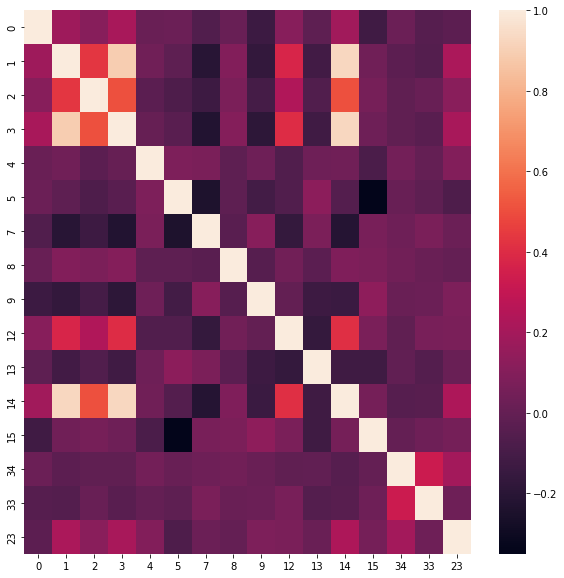

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

total_features = np.c_[ usable_features, usable_labels ]
print(total_features.shape)
print(num_features)
# column_list = list(range(num_features)) + [last_idx - 1, last_idx - 2, num_features ] 
column_list = feature_indices_to_consider + [num_features]
print( column_list )

df = pd.DataFrame(total_features, columns = column_list )
print( df.head() )

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
corr = df.corr()
sns.heatmap(corr)

In [62]:
# print(corr.shape)
# # print(corr)
# # print(usable_features)
# print(num_features)
# for i in range(num_features ): 
#     # print(corr[i][num_features])
#     if (corr[i][num_features] > 0.1 ) :
#        # print(corr[i][num_features])
#         print(i, traits[i], corr[i][num_features])
# #     for j in range(num_features):
# #         if ( corr[i][j] > 0.9 ) and ( i != j ):
# #             print(i, j, corr[i][j])

In [63]:
print(num_features)
print(traits)
print( traits[num_features - 1] )
# print(corr)

23
['Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'triglycerides', 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure', 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression', 'Non-oily fish intake', 'Hearing difficulty/problems with background noise', 'Body mass index (BMI)', 'Oily fish intake', 'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education', 'Processed meat intake', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alz

In [64]:
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])
print("Length of usable labels : ", len(usable_labels))
usable_features = torch.autograd.Variable(torch.from_numpy(usable_features)).to(DEVICE).float()

print("Usable Features : ", usable_features[:2])

Length of usable labels :  1000
Usable Features :  tensor([[ 1.2693e-01, -5.9643e-01, -1.2751e+00, -1.2437e+00,  1.0867e+00,
          9.6445e-01, -2.1641e-02, -1.8027e-01,  6.3903e-01,  9.1182e-01,
         -9.0046e-01, -1.1729e+00,  9.8911e-02,  7.9300e+01,  1.0000e+00],
        [-1.6800e-01, -1.6537e+00,  2.1332e+00, -6.9341e-01, -1.1868e+00,
          2.2892e-02,  3.3915e-01,  3.5023e-01, -6.0218e-01, -8.0206e-01,
         -9.0512e-01, -1.0479e+00,  8.4299e-01,  0.0000e+00,  0.0000e+00]])


In [ ]:
from tqdm import tqdm

GENERATE_SHAP = True
total_epochs = 500 #250(ideal)
num_features_list = [usable_features.shape[1]]
print(num_features_list)
# random_integers = [2, 6, 108, 90, 5]
random_integers = [90]#, 92, 0, 87, 73, 82, 54]

folds_list = [10]#[37*2]

avg_val_acc = []

shap_values_list = []
for num_features in num_features_list:
    print(f'NF:{num_features}')
    global_best_acc_val = 0.
    for total_folds in folds_list:
        print(f'\n#F{total_folds}')
        for random_seed in random_integers:
            N_splits = random_samples(total_folds=total_folds, random_seed=random_seed)
            accuracies = []
            accuracies_val = []
            temp_shap_values = np.zeros(usable_features.shape)
            for fold_num in tqdm(range(total_folds)):
    #             print(f'fold-{fold_num}:')
#                 train_set, val_set, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
                train_set, _, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
                val_set = test_set        
                train_loader, val_loader, test_loader = generate_loader(train_set=train_set, val_set=val_set, 
                                                                        test_set=test_set, num_workers=0)
                model = simple_model(num_features=usable_features.shape[1], hidden_dim=32)
                model = model.to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                criterion = torch.nn.BCEWithLogitsLoss() 
                best_acc_val = 0.
                model_best = None
                for epoch_num in range(total_epochs):
                    model.train()
#                     model.drop_probab=.8
                    precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=True, 
                                                                                             loader=train_loader)
                    model.eval()
#                     model.drop_probab=.0
                    precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
                                                                                             optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=False, 
                                                                                             loader=val_loader)
                    if acc_val > best_acc_val:
                        best_acc_val = acc_val
                        if acc_val > global_best_acc_val:
                            global_best_acc_val = acc_val
    #                         print('global updated!')
                        torch.save(model.state_dict(), 'PRS_model.pt')
    #                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
#                     if epoch_num + 1 == total_epochs:
#     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
#                         pass
                model_best = simple_model(num_features=usable_features.shape[1], hidden_dim=32, drop_probab=.0)
                model_best.load_state_dict(torch.load('PRS_model.pt'))
                model_best = model_best.to(DEVICE)
                model_best.eval()
                precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
                                                                                         optimizer=optimizer, 
                                                                                         criterion=criterion, is_training=False, 
                                                                                         loader=val_loader)
                accuracies += [acc_test]
                accuracies_val += [best_acc_val]
                
#                 print(fold_num, ':', accuracies)
                if GENERATE_SHAP:
                    explainer = shap.GradientExplainer(model_best.to(DEVICE), usable_features,
                                                       batch_size=usable_features.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
                    shap_values = explainer.shap_values(usable_features, nsamples=100)
#                     print("Shap values : ", shap_values)
                    temp_shap_values += shap_values 
            if GENERATE_SHAP:
                temp_shap_values /= total_folds
                shap_values_list += [temp_shap_values] 
            print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
                  np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
            avg_val_acc += [np.mean(accuracies_val)]
            
    print(f'global_best_acc_val:{global_best_acc_val}')
# usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
avg_val_acc = np.array(avg_val_acc)
print(avg_val_acc.max(), avg_val_acc.min(), avg_val_acc.mean(), avg_val_acc.std())

[15]
NF:15

#F10


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:50<02:13, 44.43s/it]

In [ ]:
save_in_file("Neural Network with " + str(hidden) + " layers", global_best_acc_val)
# save_in_file("Neural Network with " + str(hidden) + " layers", global_best_acc_val)

In [ ]:
usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
print(np.array([.67699, 0.685, 0.694, 0.687, 0.695, 0.693, 0.6849999, 0.683]).mean())
print(np.array([0.6809999999999999, 0.6889999999999998, 0.7060000000000001, 0.6910000000000001, 0.701, 0.6740000000000002, 0.6869999999999999, 0.6869999999999999]).mean())
model

In [ ]:
print( shap_values_list )

import pickle
pickle.dump(shap_values_list, open('shap_values_list.pkl', 'wb'))
shap_values = np.mean(shap_values_list, axis=0)
shap_values.shape

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
# print( shap_values_list )
# print the JS visualization code to the notebook
shap.initjs()
# print(shap_values[0, :])
# print(usable_features[0, :])
# shap.summary_plot(shap_values[:, :], usable_features[:, :])

shap.force_plot(.5, shap_values[0,:], usable_features[0, :], link = "logit", matplotlib = True)  

In [ ]:
shap.force_plot(.5, shap_values[:,:], usable_features[:, :], link="logit")

In [ ]:
# traits[20]
# shap_values = np.sum(shap_values_list)
# usable_features

In [ ]:
# GWAS_IDS = ['ieu-b-109', 'ukb-b-12064', 'ukb-b-13806', 'ukb-d-20405_0', 'ieu-b-38', 'ukb-b-6134', 'ieu-b-110', 'ukb-b-17627', 'ukb-b-19953', 'ukb-b-8476', 'ukb-d-20405_1', 'ukb-d-20405_2', 'ukb-b-2209', 'ukb-b-4424', 'ukb-b-7663', 
#             'ukb-b-18275', 'ukb-b-770', 'met-d-Total_C', 'ieu-b-25', 'ieu-b-111', 'ukb-b-3957', 'ieu-b-39', 'ukb-b-6324',
#            'ukb-a-257','ukb-b-14699','ukb-b-323']
# # new added
# # ukb-a-257 Hearing difficulty/problems: Yes
# # ukb-b-14699 Illnesses of mother: Alzheimer's disease/dementia
# # ukb-b-323 Illnesses of father: Alzheimer's disease/dementia
GWAS_IDS=[
'ukb-b-2209',
'ieu-b-39',
'ukb-b-4424',
'ukb-b-7663',
'ukb-d-20405_2',
'ukb-b-6324',
'ieu-b-111',
'ukb-b-13806',
'ieu-b-25',
'ukb-d-20405_1',
'ukb-b-14699',
'ukb-b-770',
'ieu-b-109',
'ukb-d-20405_0',
'ieu-b-110',
'ukb-b-17627',
'ukb-a-257',
'ieu-b-38',
'ukb-b-18275',
'ukb-b-3957'   
]

# traits = ['HDL cholesterol', 'Non-cancer illness code, self-reported: depression', 
#           'Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 
#           'systolic blood pressure', 'Age completed full time education', 'LDL cholesterol', 
#           'Non-oily fish intake', 'Body mass index (BMI)', 'Loneliness, isolation', 
#           'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 
#           'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year',
#           'Oily fish intake', 'Sleep duration', 'Types of physical activity in last 4 weeks: Strenuous sports', 
#           'Hearing difficulty/problems with background noise', 'Other meat intake', 'Total cholesterol', 
#           'Cigarettes per Day', 'triglycerides', 'Sleeplessness / insomnia', 'diastolic blood pressure', 
#           'Processed meat intake','Hearing difficulty/problems: Yes','Illnesses of mother: Alzheimer\'s disease/dementia','Illnesses of father: Alzheimer\'s di



# for GWAS_ID in GWAS_IDS:
#     print(GWAS_ID)
# traits = ['HDL cholesterol', 'Non-cancer illness code, self-reported: depression', 
#           'Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 
#           'systolic blood pressure', 'Age completed full time education', 'LDL cholesterol', 
#           'Non-oily fish intake', 'Body mass index (BMI)', 'Loneliness, isolation', 
#           'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 
#           'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year',
#           'Oily fish intake', 'Sleep duration', 'Types of physical activity in last 4 weeks: Strenuous sports', 
#           'Hearing difficulty/problems with background noise', 'Other meat intake', 'Total cholesterol', 
#           'Cigarettes per Day', 'triglycerides', 'Sleeplessness / insomnia', 'diastolic blood pressure', 
#           'Processed meat intake','Hearing difficulty/problems: Yes','Illnesses of mother: Alzheimer\'s disease/dementia','Illnesses of father: Alzheimer\'s disease/dementia']

# # https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# # usable_features_std = (usable_features - usable_features.mean(0))/usable_features.std(0)
# shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot', max_display=len(traits))

In [ ]:
import json
# in place of json straight took it hardcoded

all_traits = json.load(open('traits_map.json', 'r'))
# print(all_traits)
GWAS_IDS = list(all_traits)
# print(GWAS_IDS)
traits = [all_traits[x] for x in all_traits]
print(len(traits))
# for trait in traits:
#     print(trait)
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# usable_features_std = (usable_features - usable_features.mean(0))/usable_features.std(0)
shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot', max_display=len(traits), show = False)
plt.savefig('shap/' + str(num_features) + '/summary_plot_hidden_'+ str(hidden) + '_dim_' + str(hidden_dimension) + '.pdf',  bbox_inches='tight')
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='dot', max_display=len(traits))

In [ ]:
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')
# naeem modified
shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(num_features)), plot_type='bar', max_display=len(traits), show=False)
plt.savefig('shap/summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

In [ ]:
sorted(list(zip(list(range(23)), abs(shap_values).mean(0))), key=lambda x:x[1], reverse=True)

In [ ]:
help(shap.force_plot)


In [ ]:

# # print(Final_Samples)
# from sklearn.model_selection import train_test_split
# from sklearn import svm
# from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM

# feature_indices_to_consider = list(range(0, 23)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]

# usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
# usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
# usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])

# Final_Samples = positive_samples[:500] + negative_samples[:500]
# random.seed(2);random.shuffle(Final_Samples)
# # Final_Samples = np.array(Final_Samples)
# print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
# print(sum(usable_labels), len(usable_labels))

# X_train, X_test, y_train, y_test = train_test_split(
#     usable_features, usable_labels, test_size=0.1)

# X_train.shape, y_train.shape

# X_test.shape, y_test.shape

# print(y_test.sum(), y_test.shape)
# clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
# # clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam').fit(X_train, y_train)
# clf.score(X_test, y_test)

In [ ]:
# random.shuffle(Final_Samples)
# usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
# usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
# usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])


# from sklearn.model_selection import KFold
# X = usable_features[:, :23]
# y = usable_labels
# kf = KFold(n_splits=10)
# kf.get_n_splits(X)

# print(kf)
# # print(y_test)
# accuracies = []
# for train_index, test_index in kf.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
# #     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
# #     print(y_test.sum(), y_test.shape)
#     print(clf.score(X_test, y_test))
#     accuracies += [clf.score(X_test, y_test)]
# print(np.mean(accuracies), np.std(accuracies))


In [ ]:
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# accuracies = []
# X = usable_features[:, :23]
# y = usable_labels
# kf = KFold(n_splits=10)
# kf.get_n_splits(X)

# for train_index, test_index in kf.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     reg = RandomForestClassifier(random_state=0)
#     reg.fit(X_train, y_train)
#     print("Accuracy of model : ",reg.score(X_test, y_test)*100,"%")
# #     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
# #     print(y_test.sum(), y_test.shape)
#     accuracies += [reg.score(X_test, y_test)]
# print(np.mean(accuracies), np.std(accuracies))
# save_in_file("Random Forest", np.mean(accuracies))

In [ ]:
# from xgboost import XGBRegressor, XGBClassifier
# model_name = "XGB"

# accuracies = []
# for train_index, test_index in kf.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     reg = XGBClassifier()
#     reg.fit(X_train, y_train)
#     print("Accuracy of model : ",reg.score(X_test, y_test)*100,"%")
# #     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
# #     print(y_test.sum(), y_test.shape)
#     accuracies += [reg.score(X_test, y_test)]
# print(np.mean(accuracies), np.std(accuracies))
# save_in_file("XGBoost", np.mean(accuracies))


In [ ]:
import csv

# open the file in the write mode
f = open('model_global_best_accuracy.csv', 'a')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(['num_features','num_nn_layers','global_best_accuracy'])
writer.writerow([str(num_features),str(hidden),str(global_best_acc_val)])

# close the file
f.close()

0, 2, 10, 15, 16, 18, 20 = > 0.1

0, 1, 2, 4, 7, 9, 10, 12, 14, 15, 16, 18, 19, 20, 21 = > 0.05

input folder 2 ->

Non-cancer illness code, self-reported: head injury 0.039592552468682124
Body mass index (BMI) 0.058239582318606924
Hearing difficulty/problems with background noise 0.15743567844006626
Loneliness, isolation 0.15237887969196875
systolic blood pressure 0.06436870562722181
Cigarettes per Day 0.010885022560524186
Total cholesterol 0.06411924471864067
Types of physical activity in last 4 weeks: Strenuous sports 0.15120628499122302
Hearing difficulty/problems: Yes 0.14234343101905772
Non-cancer illness code, self-reported: anxiety/panic attacks 0.1028817244996895
Non-oily fish intake 0.015021203306737466
Mood swings 0.14040431070709875
Non-cancer illness code, self-reported: hypothyroidism/myxoedema 0.13996357841056675
Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year 0.14267358626525073
LDL cholesterol 0.06068242295284047
Non-cancer illness code, self-reported: stroke 0.04681484270044513
Diagnoses - secondary ICD10: E66.9 Obesity, unspecified 0.032964755339817305
Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year 0.12881051761139867
triglycerides 0.016785962311147724
Processed meat intake 0.06644719024848708
diastolic blood pressure 0.04298568696001545
Non-cancer illness code, self-reported: hyperthyroidism/thyrotoxicosis 0.06425389173946594
Ever had known person concerned about, or recommend reduction of, alcohol consumption: No 0.15006266931430515


---------------------------------------------------------------------------------------------------------------------------

Non-cancer illness code, self-reported: stroke 0.039578527736042445
Non-cancer illness code, self-reported: hypothyroidism/myxoedema 0.1100777719255633
Hearing difficulty/problems with background noise 0.1136800098682467
Body mass index (BMI) 0.06116282231897628
Processed meat intake 0.029403212191491973
Non-oily fish intake 0.046597976887788314
Total cholesterol 0.12157843064472068
systolic blood pressure 0.06084755678346411
diastolic blood pressure 0.028225911433022003
Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year 0.1048490737269721
Non-cancer illness code, self-reported: head injury 0.06288185597512133
Loneliness, isolation 0.12940334910335374
Ever had known person concerned about, or recommend reduction of, alcohol consumption: No 0.12497170186758892
Non-cancer illness code, self-reported: hyperthyroidism/thyrotoxicosis 0.04725147537191196
Mood swings 0.11696054297668732
Non-cancer illness code, self-reported: anxiety/panic attacks 0.0876726970125181
Cigarettes per Day 0.03201410857443325
Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year 0.08383082915298443
Hearing difficulty/problems: Yes 0.11411392823746933
LDL cholesterol 0.08615630266204458
triglycerides 0.04310713631325058
Types of physical activity in last 4 weeks: Strenuous sports 0.1235076264552588

----------------------------------------------------------------------------------------------------------------------------


input folder 0 ->

Non-cancer illness code, self-reported: stroke 0.03617634912248311
Non-cancer illness code, self-reported: hypothyroidism/myxoedema 0.1523474232009029
Hearing difficulty/problems with background noise 0.16523562624177535
Body mass index (BMI) 0.10152734549719254
Processed meat intake 0.07042328713209409
Other meat intake 0.02254460248760014
Total cholesterol 0.09647425753535764
systolic blood pressure 0.057106167022093354
diastolic blood pressure 0.04668285014558331
Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year 0.16683462286785886
Non-cancer illness code, self-reported: head injury 0.04847177910270192
Loneliness, isolation 0.18512514945646039
Ever had known person concerned about, or recommend reduction of, alcohol consumption: No 0.1770118554936706
Non-cancer illness code, self-reported: hyperthyroidism/thyrotoxicosis 0.08840591939305809
Mood swings 0.17670200186496124
Non-cancer illness code, self-reported: anxiety/panic attacks 0.09829447772644583
Cigarettes per Day 0.050202052935900604
Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year 0.11739096255902988
Hearing difficulty/problems: Yes 0.1610328131068411
LDL cholesterol 0.06477203421118846
triglycerides 0.023888054560001707